In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as st
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
#import xesmf as xe
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import glob
from sys import exit, argv
import netCDF4 as nc4
from distributed import Client
from h5py import File
from pyhdf.SD import SD, SDC
import re
from datetime import datetime

import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader

from matplotlib.font_manager import FontProperties
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

import cmocean.cm as cmo


In [2]:
#Path to data
data_path = '/Users/ashneelchandra/OneDrive - The University of Melbourne/Graduate Colloquium - Global Hackathon/hackathon/hk25-AusNode-ExtremePrecipitation/Data/Stations/Fiji_Meteorological_Service/'


In [3]:
#Station locations (you can comment/uncomment the stations you do not need or need)
lon_array = []
lat_array = []

#Suva (Manual)
lat_station = -18.147571
lon_station = 178.453610
lat_array.append(lat_station)
lon_array.append(lon_station)   

#Suva (AWS)
lat_station = -18.147549
lon_station = 178.453608
lat_array.append(lat_station)
lon_array.append(lon_station) 

#Lautoka (Manual)
lat_station = -17.618600
lon_station = 177.438900
lat_array.append(lat_station)
lon_array.append(lon_station) 

#Lautoka (TB3)
lat_station = -17.618897
lon_station = 177.438730
lat_array.append(lat_station)
lon_array.append(lon_station) 

#Penang (TB3)
lat_station = -17.373833
lon_station = 178.171619
lat_array.append(lat_station)
lon_array.append(lon_station) 

#Savusavu (Airport)
lat_station = -16.806141
lon_station = 179.342817
lat_array.append(lat_station)
lon_array.append(lon_station) 

#Labasa (Airport)
lat_station = -16.468900
lon_station = 179.339700
lat_array.append(lat_station)
lon_array.append(lon_station) 

#Station names array
station_names = ['Suva (Manual)', 'Suva (AWS)', 'Lautoka (Manual)', 'Lautoka (TB3)', 'Penang (TB3)', 'Savusavu (Airport)', 'Labasa (Airport)']


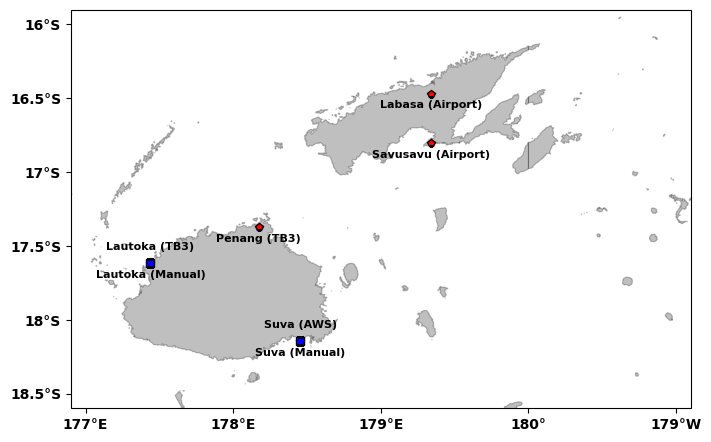

In [5]:
# Plot Fiji map and station locations


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[8, 8], subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define the font properties for legend and tick labels
legend_font = FontProperties()
legend_font.set_size(10)
legend_font.set_weight('bold')
tick_font = FontProperties()
tick_font.set_size(10)
tick_font.set_weight('bold')

ax = axes  # Access the current subplot
ax.set_aspect(1)  # Set aspect ratio

# Add high-resolution coastlines
#ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
#ax.add_feature(cfeature.LAND, color='none', zorder=0, linewidth=1, edgecolor='black', alpha=0.25)
#ax.coastlines(resolution='50m', linewidth=0.5, color='black')
ax.add_feature(cfeature.GSHHSFeature(scale="full"), color='black', zorder=1, linewidth=0.8, edgecolor='black', alpha=0.25)

for i in range(len(lon_array)):
    # Plot points
    if i == 1 or i == 3:
        ax.plot(lon_array[i] - 180, lat_array[i], 'sk', markersize=6, markerfacecolor='b', markeredgecolor='k')
    else:
        ax.plot(lon_array[i] - 180, lat_array[i], 'pk', markersize=6, markerfacecolor='r', markeredgecolor='k')

    # Add text annotations
    if i == 1 or i == 3:
        ax.text(lon_array[i] - 180, lat_array[i] + 0.095, station_names[i], fontsize=8, fontweight='bold', ha='center')
    else:
        ax.text(lon_array[i] - 180, lat_array[i] - 0.095, station_names[i], fontsize=8, fontweight='bold', ha='center')

    
# Customize tick labels and limits
ax.set_xlim([176.9-180, 181.1-180])
ax.set_ylim([-18.6, -15.9])
ax.set_xticks(np.arange(177-180, 182-180, 1.0))
ax.set_yticks(np.arange(-18.5, -15.5, 0.5))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=tick_font)
ax.set_yticklabels(ax.get_yticks(), fontproperties=tick_font)

# Format longitude and latitude labels
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

plt.savefig(data_path + 'Fiji_station_locations_new.jpg', dpi=600, bbox_inches='tight', pad_inches=0.0)
plt.savefig(data_path + 'Fiji_station_locations_new.pdf', format='pdf', bbox_inches='tight', pad_inches=0.0)



In [6]:
#Compute mean TRMM rainfall (from 3 hourly data) (1998-01-01 to 2019-12-31)
trmm_path = '/Users/ashneelchandra/Library/CloudStorage/Dropbox/documents/Data/TRMM_3B42/precipitation/' #Path to TRMM data
trmm_data = xr.open_mfdataset(trmm_path + 'TRMM.precipitation.1998-2019.3hour.nc')
print(trmm_data)
#trmm_mean_3hourly = trmm_data.precipitation.mean(dim='time')
#print(trmm_mean_3hourly)
#trmm_mean_3hourly.to_netcdf(data_path + 'TRMM_mean_3hourly_1998-2019.nc')
#trmm_mean_daily = trmm_data.resample(time="1D").sum().mean(dim='time')
#print(trmm_mean_daily)
#trmm_mean_daily.to_netcdf(data_path + 'TRMM_mean_daily_1998-2019.nc')
trmm_mean_yearly = trmm_data.resample(time="1Y").sum().mean(dim='time')
print(trmm_mean_yearly)
trmm_mean_yearly.to_netcdf(data_path + 'TRMM_mean_yearly_1998-2019.nc')

<xarray.Dataset> Size: 148GB
Dimensions:        (time: 64280, lat: 400, lon: 1440)
Coordinates:
  * time           (time) datetime64[ns] 514kB 1998-01-01 ... 2019-12-31T21:0...
  * lat            (lat) float64 3kB -49.88 -49.62 -49.38 ... 49.38 49.62 49.88
  * lon            (lon) float64 12kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    precipitation  (time, lat, lon) float32 148GB dask.array<chunksize=(1, 400, 1440), meta=np.ndarray>


/Users/ashneelchandra/miniforge3/lib/python3.12/site-packages/xarray/groupers.py:498: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


<xarray.Dataset> Size: 2MB
Dimensions:        (lat: 400, lon: 1440)
Coordinates:
  * lat            (lat) float64 3kB -49.88 -49.62 -49.38 ... 49.38 49.62 49.88
  * lon            (lon) float64 12kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    precipitation  (lat, lon) float32 2MB dask.array<chunksize=(400, 1440), meta=np.ndarray>


(400, 1440)
(400, 1441)
[1.25000e-01 3.75000e-01 6.25000e-01 ... 3.59625e+02 3.59875e+02
 3.60125e+02]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


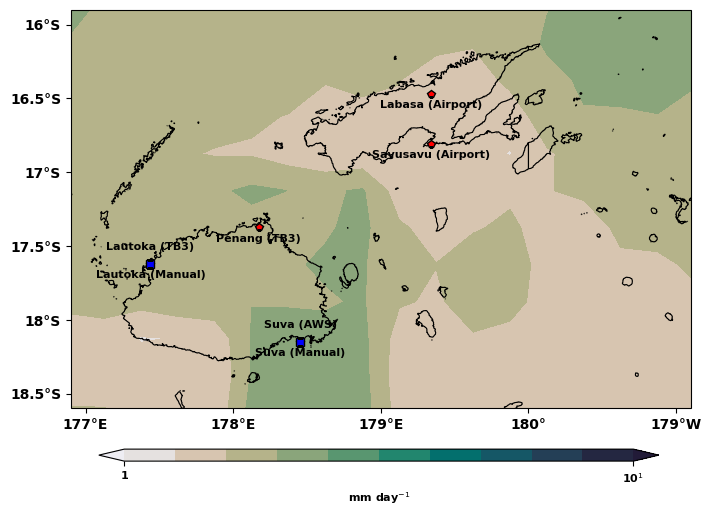

In [14]:

#Plot map of Fiji with location of stations and precipitation climatology from 3 hourly TRMM data (daily mean)
trmm_mean_daily = xr.open_dataset(data_path + 'TRMM_mean_daily_1998-2019.nc')
cyclic_trmm, cyclic_lon = add_cyclic_point(trmm_mean_daily.precipitation, coord=trmm_mean_daily.lon, axis=1)
print(trmm_mean_daily.precipitation.shape)
print(cyclic_trmm.shape)
print(cyclic_lon)

#vmn = 0
#vmx = 0.5
#intvl = 0.05
#lvl =  (np.arange(vmn,vmx+(intvl*1),intvl*1))

scale = 1 #1000
vmn = np.log10(1*scale)
vmx = np.log10(10*scale)
tcks = np.arange(0,2,1)
intvl = 1*scale
lvl =  (np.arange(vmn,vmx+(intvl*0.1),intvl*0.1))

print(lvl)
colormap = cmo.rain

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[8, 8], subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define the font properties for legend and tick labels
legend_font = FontProperties()
legend_font.set_size(10)
legend_font.set_weight('bold')
tick_font = FontProperties()
tick_font.set_size(10)
tick_font.set_weight('bold')

ax = axes  # Access the current subplot
ax.set_aspect(1)  # Set aspect ratio

# Add high-resolution coastlines
#ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
#ax.add_feature(cfeature.LAND, color='none', zorder=0, linewidth=1, edgecolor='black', alpha=0.25)
#ax.coastlines(resolution='50m', linewidth=0.5, color='black')
ax.add_feature(cfeature.GSHHSFeature(scale="full"), facecolor='none', zorder=1, linewidth=0.8, edgecolor='black', alpha=1)
# Add TRMM data
plt_cn = ax.contourf(cyclic_lon - 180,trmm_mean_daily['lat'],np.log10(cyclic_trmm),extend='both',cmap=colormap, levels=lvl, vmin=vmn, vmax=vmx, zorder=0, transform=ccrs.PlateCarree(central_longitude=180))

for i in range(len(lon_array)):
    # Plot points
    if i == 1 or i == 3:
        ax.plot(lon_array[i] - 180, lat_array[i], 'sk', markersize=6, markerfacecolor='b', markeredgecolor='k')
    else:
        ax.plot(lon_array[i] - 180, lat_array[i], 'pk', markersize=6, markerfacecolor='r', markeredgecolor='k')

    # Add text annotations
    if i == 1 or i == 3:
        ax.text(lon_array[i] - 180, lat_array[i] + 0.095, station_names[i], fontsize=8, fontweight='bold', ha='center')
    else:
        ax.text(lon_array[i] - 180, lat_array[i] - 0.095, station_names[i], fontsize=8, fontweight='bold', ha='center')

    
# Customize tick labels and limits
ax.set_xlim([176.9-180, 181.1-180])
ax.set_ylim([-18.6, -15.9])
ax.set_xticks(np.arange(177-180, 182-180, 1.0))
ax.set_yticks(np.arange(-18.5, -15.5, 0.5))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=tick_font)
ax.set_yticklabels(ax.get_yticks(), fontproperties=tick_font)

# Format longitude and latitude labels
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

#Colorbar for TRMM clim
cbar_ax = fig.add_axes([0.16, 0.18, 0.70, 0.015])
cbar = fig.colorbar(plt_cn, cax=cbar_ax, orientation='horizontal', label= 'mm day$^{-1}$', ticks=tcks, shrink=0.8)
#cbar.set_ticks(np.arange(0,0.6,0.1))
cbar.ax.set_xticklabels(['1', '10$^{1}$'])
cbar.ax.tick_params(labelsize=10)  # Adjust fontsize for colorbar tick labels
cbar.ax.xaxis.label.set_size(10)   # Adjust fontsize for colorbar label
#cbar.set_label('m $s^{-1}$')

for label in cbar_ax.get_xticklabels():
            label.set_fontsize(8)
            label.set_fontweight('bold')
cbar_ax.xaxis.label.set_size(8)
cbar_ax.xaxis.label.set_fontweight('bold')

plt.savefig(data_path + 'Fiji_station_locations_TRMM_daily_mean.jpg', dpi=600, bbox_inches='tight', pad_inches=0.0)
plt.savefig(data_path + 'Fiji_station_locations_TRMM_daily_mean.pdf', format='pdf', bbox_inches='tight', pad_inches=0.0)



(400, 1440)
(400, 1441)
[1.25000e-01 3.75000e-01 6.25000e-01 ... 3.59625e+02 3.59875e+02
 3.60125e+02]
[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4. ]


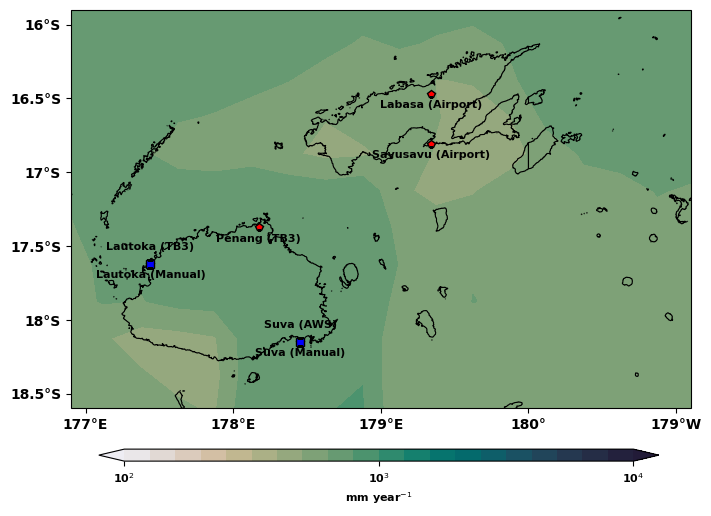

In [21]:

#Plot map of Fiji with location of stations and precipitation climatology from 3 hourly TRMM data (yearly mean)
trmm_mean_yearly = xr.open_dataset(data_path + 'TRMM_mean_yearly_1998-2019.nc')
cyclic_trmm, cyclic_lon = add_cyclic_point(trmm_mean_yearly.precipitation, coord=trmm_mean_yearly.lon, axis=1)
print(trmm_mean_yearly.precipitation.shape)
print(cyclic_trmm.shape)
print(cyclic_lon)

#vmn = 0
#vmx = 0.5
#intvl = 0.05
#lvl =  (np.arange(vmn,vmx+(intvl*1),intvl*1))

scale = 1 #1000
vmn = np.log10(100*scale)
vmx = np.log10(10000*scale)
tcks = np.arange(2,5,1)
intvl = 1*scale
lvl =  (np.arange(vmn,vmx+(intvl*0.1),intvl*0.1))

print(lvl)
colormap = cmo.rain

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[8, 8], subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define the font properties for legend and tick labels
legend_font = FontProperties()
legend_font.set_size(10)
legend_font.set_weight('bold')
tick_font = FontProperties()
tick_font.set_size(10)
tick_font.set_weight('bold')

ax = axes  # Access the current subplot
ax.set_aspect(1)  # Set aspect ratio

# Add high-resolution coastlines
#ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
#ax.add_feature(cfeature.LAND, color='none', zorder=0, linewidth=1, edgecolor='black', alpha=0.25)
#ax.coastlines(resolution='50m', linewidth=0.5, color='black')
ax.add_feature(cfeature.GSHHSFeature(scale="full"), facecolor='none', zorder=1, linewidth=0.8, edgecolor='black', alpha=1)
# Add TRMM data
plt_cn = ax.contourf(cyclic_lon - 180,trmm_mean_daily['lat'],np.log10(cyclic_trmm),extend='both',cmap=colormap, levels=lvl, vmin=vmn, vmax=vmx, zorder=0, transform=ccrs.PlateCarree(central_longitude=180))

for i in range(len(lon_array)):
    # Plot points
    if i == 1 or i == 3:
        ax.plot(lon_array[i] - 180, lat_array[i], 'sk', markersize=6, markerfacecolor='b', markeredgecolor='k')
    else:
        ax.plot(lon_array[i] - 180, lat_array[i], 'pk', markersize=6, markerfacecolor='r', markeredgecolor='k')

    # Add text annotations
    if i == 1 or i == 3:
        ax.text(lon_array[i] - 180, lat_array[i] + 0.095, station_names[i], fontsize=8, fontweight='bold', ha='center')
    else:
        ax.text(lon_array[i] - 180, lat_array[i] - 0.095, station_names[i], fontsize=8, fontweight='bold', ha='center')

    
# Customize tick labels and limits
ax.set_xlim([176.9-180, 181.1-180])
ax.set_ylim([-18.6, -15.9])
ax.set_xticks(np.arange(177-180, 182-180, 1.0))
ax.set_yticks(np.arange(-18.5, -15.5, 0.5))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=tick_font)
ax.set_yticklabels(ax.get_yticks(), fontproperties=tick_font)

# Format longitude and latitude labels
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

#Colorbar for TRMM clim
cbar_ax = fig.add_axes([0.16, 0.18, 0.70, 0.015])
cbar = fig.colorbar(plt_cn, cax=cbar_ax, orientation='horizontal', label= 'mm year$^{-1}$', ticks=tcks, shrink=0.8)
#cbar.set_ticks(np.arange(0,0.6,0.1))
cbar.ax.set_xticklabels(['10$^{2}$', '10$^{3}$', '10$^{4}$'])
cbar.ax.tick_params(labelsize=10)  # Adjust fontsize for colorbar tick labels
cbar.ax.xaxis.label.set_size(10)   # Adjust fontsize for colorbar label
#cbar.set_label('m $s^{-1}$')

for label in cbar_ax.get_xticklabels():
            label.set_fontsize(8)
            label.set_fontweight('bold')
cbar_ax.xaxis.label.set_size(8)
cbar_ax.xaxis.label.set_fontweight('bold')

plt.savefig(data_path + 'Fiji_station_locations_TRMM_yearly_mean.jpg', dpi=600, bbox_inches='tight', pad_inches=0.0)
plt.savefig(data_path + 'Fiji_station_locations_TRMM_yearly_mean.pdf', format='pdf', bbox_inches='tight', pad_inches=0.0)



(400, 1440)
(400, 1441)
[1.25000e-01 3.75000e-01 6.25000e-01 ... 3.59625e+02 3.59875e+02
 3.60125e+02]
[-2.00000000e+00 -1.90000000e+00 -1.80000000e+00 -1.70000000e+00
 -1.60000000e+00 -1.50000000e+00 -1.40000000e+00 -1.30000000e+00
 -1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  1.77635684e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00]


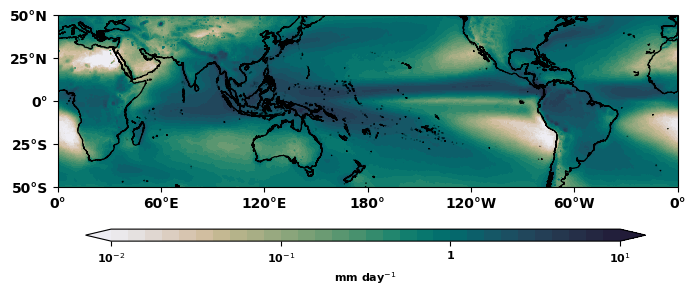

In [ ]:

#Plot precipitation climatology from 3 hourly TRMM data (daily mean)
trmm_mean_daily = xr.open_dataset(data_path + 'TRMM_mean_daily_1998-2019.nc')
cyclic_trmm, cyclic_lon = add_cyclic_point(trmm_mean_daily.precipitation, coord=trmm_mean_daily.lon, axis=1)
print(trmm_mean_daily.precipitation.shape)
print(cyclic_trmm.shape)
print(cyclic_lon)

#vmn = 0
#vmx = 0.5
#intvl = 0.05
#lvl =  (np.arange(vmn,vmx+(intvl*1),intvl*1))

scale = 1 #1000
vmn = np.log10(0.01*scale)
vmx = np.log10(10*scale)
tcks = np.arange(-2,2,1)
intvl = 1*scale
lvl =  (np.arange(vmn,vmx+(intvl*0.1),intvl*0.1))

print(lvl)
colormap = cmo.rain

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[8, 8], subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define the font properties for legend and tick labels
legend_font = FontProperties()
legend_font.set_size(10)
legend_font.set_weight('bold')
tick_font = FontProperties()
tick_font.set_size(10)
tick_font.set_weight('bold')

ax = axes  # Access the current subplot
ax.set_aspect(1)  # Set aspect ratio

# Add high-resolution coastlines
#ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
#ax.add_feature(cfeature.LAND, color='none', zorder=0, linewidth=1, edgecolor='black', alpha=0.25)
#ax.coastlines(resolution='50m', linewidth=0.5, color='black')
ax.add_feature(cfeature.GSHHSFeature(scale="full"), facecolor='none', zorder=1, linewidth=0.8, edgecolor='black', alpha=1)
# Add TRMM data
plt_cn = ax.contourf(cyclic_lon - 180,trmm_mean_daily['lat'],np.log10(cyclic_trmm),extend='both',cmap=colormap, levels=lvl, vmin=vmn, vmax=vmx, zorder=0, transform=ccrs.PlateCarree(central_longitude=180))

# Customize tick labels and limits
ax.set_xlim([0-180, 360-180])
ax.set_ylim([-50, 50])
ax.set_xticks(np.arange(0-180, 420-180, 60.0))
ax.set_yticks(np.arange(-50, 75, 25))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=tick_font)
ax.set_yticklabels(ax.get_yticks(), fontproperties=tick_font)

# Format longitude and latitude labels
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

#Colorbar for TRMM clim
cbar_ax = fig.add_axes([0.16, 0.32, 0.70, 0.015])
cbar = fig.colorbar(plt_cn, cax=cbar_ax, orientation='horizontal', label= 'mm day$^{-1}$', ticks=tcks, shrink=0.8)
#cbar.set_ticks(np.arange(0,0.6,0.1))
cbar.ax.set_xticklabels(['10$^{-2}$', '10$^{-1}$', '1', '10$^{1}$'])
cbar.ax.tick_params(labelsize=10)  # Adjust fontsize for colorbar tick labels
cbar.ax.xaxis.label.set_size(10)   # Adjust fontsize for colorbar label
#cbar.set_label('m $s^{-1}$')

for label in cbar_ax.get_xticklabels():
            label.set_fontsize(8)
            label.set_fontweight('bold')
cbar_ax.xaxis.label.set_size(8)
cbar_ax.xaxis.label.set_fontweight('bold')

plt.savefig(data_path + 'TRMM_daily_mean.jpg', dpi=600, bbox_inches='tight', pad_inches=0.0)
plt.savefig(data_path + 'TRMM_daily_mean.pdf', format='pdf', bbox_inches='tight', pad_inches=0.0)



(400, 1440)
(400, 1441)
[1.25000e-01 3.75000e-01 6.25000e-01 ... 3.59625e+02 3.59875e+02
 3.60125e+02]
[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4. ]


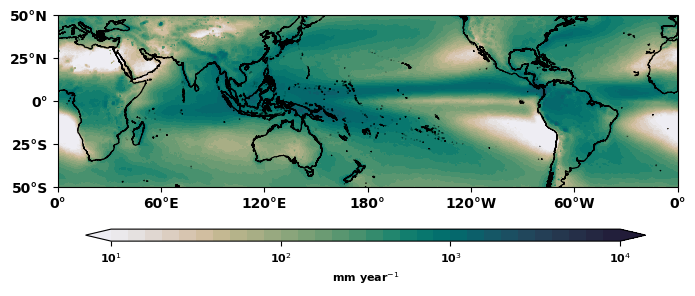

In [23]:

#Plot precipitation climatology from 3 hourly TRMM data (yearly mean)
trmm_mean_yearly = xr.open_dataset(data_path + 'TRMM_mean_yearly_1998-2019.nc')
cyclic_trmm, cyclic_lon = add_cyclic_point(trmm_mean_yearly.precipitation, coord=trmm_mean_yearly.lon, axis=1)
print(trmm_mean_yearly.precipitation.shape)
print(cyclic_trmm.shape)
print(cyclic_lon)

#vmn = 0
#vmx = 0.5
#intvl = 0.05
#lvl =  (np.arange(vmn,vmx+(intvl*1),intvl*1))

scale = 1 #1000
vmn = np.log10(10*scale)
vmx = np.log10(10000*scale)
tcks = np.arange(1,5,1)
intvl = 1*scale
lvl =  (np.arange(vmn,vmx+(intvl*0.1),intvl*0.1))

print(lvl)
colormap = cmo.rain

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=[8, 8], subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define the font properties for legend and tick labels
legend_font = FontProperties()
legend_font.set_size(10)
legend_font.set_weight('bold')
tick_font = FontProperties()
tick_font.set_size(10)
tick_font.set_weight('bold')

ax = axes  # Access the current subplot
ax.set_aspect(1)  # Set aspect ratio

# Add high-resolution coastlines
#ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
#ax.add_feature(cfeature.LAND, color='none', zorder=0, linewidth=1, edgecolor='black', alpha=0.25)
#ax.coastlines(resolution='50m', linewidth=0.5, color='black')
ax.add_feature(cfeature.GSHHSFeature(scale="full"), facecolor='none', zorder=1, linewidth=0.8, edgecolor='black', alpha=1)
# Add TRMM data
plt_cn = ax.contourf(cyclic_lon - 180,trmm_mean_daily['lat'],np.log10(cyclic_trmm),extend='both',cmap=colormap, levels=lvl, vmin=vmn, vmax=vmx, zorder=0, transform=ccrs.PlateCarree(central_longitude=180))

# Customize tick labels and limits
ax.set_xlim([0-180, 360-180])
ax.set_ylim([-50, 50])
ax.set_xticks(np.arange(0-180, 420-180, 60.0))
ax.set_yticks(np.arange(-50, 75, 25))
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=tick_font)
ax.set_yticklabels(ax.get_yticks(), fontproperties=tick_font)

# Format longitude and latitude labels
ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

#Colorbar for TRMM clim
cbar_ax = fig.add_axes([0.16, 0.32, 0.70, 0.015])
cbar = fig.colorbar(plt_cn, cax=cbar_ax, orientation='horizontal', label= 'mm year$^{-1}$', ticks=tcks, shrink=0.8)
#cbar.set_ticks(np.arange(0,0.6,0.1))
cbar.ax.set_xticklabels(['10$^{1}$', '10$^{2}$', '10$^{3}$', '10$^{4}$'])
cbar.ax.tick_params(labelsize=10)  # Adjust fontsize for colorbar tick labels
cbar.ax.xaxis.label.set_size(10)   # Adjust fontsize for colorbar label
#cbar.set_label('m $s^{-1}$')

for label in cbar_ax.get_xticklabels():
            label.set_fontsize(8)
            label.set_fontweight('bold')
cbar_ax.xaxis.label.set_size(8)
cbar_ax.xaxis.label.set_fontweight('bold')

plt.savefig(data_path + 'TRMM_yearly_mean.jpg', dpi=600, bbox_inches='tight', pad_inches=0.0)
plt.savefig(data_path + 'TRMM_yearly_mean.pdf', format='pdf', bbox_inches='tight', pad_inches=0.0)

